### 1. Load Train / Test / Validation Data Files

In [1]:
import numpy as np

In [2]:
train_features_path =  "../feature/BENGALI-feature/train_features_triplet_loss_set.npy"
train_names_path = "../feature/BENGALI-feature/train_names.npy"
train_labels_path = "../feature/BENGALI-feature/train_labels.npy"

test_features_path = "../feature/BENGALI-feature/test_features_triplet_loss_set.npy"
test_names_path = "../feature/BENGALI-feature/test_names.npy"
test_labels_path = "../feature/BENGALI-feature/test_labels.npy"

validation_features_path = "../feature/BENGALI-feature/validation_features_triplet_loss_set.npy"
validation_names_path = "../feature/BENGALI-feature/validation_names.npy"
validation_labels_path = "../feature/BENGALI-feature/validation_labels.npy"

gallery_feature_path = "../feature/BENGALI-feature/gallery_features_triplet_loss_set.npy"
gallery_name_path = "../feature/BENGALI-feature/gallery_names.npy"

train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

validation_features = np.load(validation_features_path)
validation_names = np.load(validation_names_path)
validation_labels = np.load(validation_labels_path)

gallery_features = np.load(gallery_feature_path)
gallery_names = np.load(gallery_name_path)

In [3]:
print(train_features.shape)
print(train_labels.shape)
print(train_names.shape)
print(test_features.shape)
print(test_labels.shape)
print(test_names.shape)
print(validation_features.shape)
print(validation_labels.shape)
print(validation_names.shape)
print(gallery_features.shape)
print(gallery_names.shape)

(3200, 512)
(3200,)
(3200,)
(1100, 512)
(1100,)
(1100,)
(1100, 512)
(1100,)
(1100,)
(100, 512)
(100,)


In [4]:
def find_difference_vector(vector_features, vector_labels, vector_names, gallery_features, gallery_names):
    difference_vectors = []
    difference_names = []
    difference_labels = []

    for gallery_feature, gallery_name in zip(gallery_features, gallery_names):
        curr_difference_name = gallery_name
        curr_difference_feature = []
        curr_difference_label = []
        curr_difference = []
        
        for feature, name, label in zip(vector_features, vector_names, vector_labels):
            # print(f"Gallery Name: {gallery_name}, Name: {name}")
            if gallery_name == name:
                curr_difference_feature.append(feature)
                curr_difference_label.append(label)
        
        if curr_difference_feature:  # Check if the list is not empty
            # Assuming curr_difference_feature, curr_difference_label, and gallery_feature are numpy arrays
            curr_difference_feature = np.array(curr_difference_feature)
            curr_difference_label = np.array(curr_difference_label)
            curr_difference = curr_difference_feature - gallery_feature

            difference_vectors.append(curr_difference)
            difference_names.append(curr_difference_name)
            difference_labels.append(curr_difference_label)
            
    return difference_vectors, difference_names, difference_labels

In [5]:
test_difference_vectors, test_difference_names, test_difference_labels = find_difference_vector(test_features, test_labels, test_names, gallery_features, gallery_names)
train_difference_vectors, train_difference_names, train_difference_labels = find_difference_vector(train_features, train_labels, train_names, gallery_features, gallery_names)
validation_difference_vectors, validation_difference_names, validation_difference_labels = find_difference_vector(validation_features, validation_labels, validation_names, gallery_features, gallery_names)

### 2. Train on ML

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [7]:
# For Train Set
train_difference_vectors_flat = [item for sublist in train_difference_vectors for item in sublist]
train_difference_array = np.array(train_difference_vectors_flat).reshape(len(train_difference_vectors_flat), -1)

# For test set
test_difference_vectors_flat = [item for sublist in test_difference_vectors for item in sublist]
test_difference_array = np.array(test_difference_vectors_flat).reshape(len(test_difference_vectors_flat), -1)

# For validation set
validation_difference_vectors_flat = [item for sublist in validation_difference_vectors for item in sublist]
validation_difference_array = np.array(validation_difference_vectors_flat).reshape(len(validation_difference_vectors_flat), -1)

In [8]:
print(train_difference_array.shape)
print(train_labels.shape)
print(test_difference_array.shape)
print(test_labels.shape)
print(validation_difference_array.shape)
print(validation_labels.shape)

(3200, 512)
(3200,)
(1100, 512)
(1100,)
(1100, 512)
(1100,)


In [9]:
model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees (n_estimators) based on your needs
model.fit(train_difference_array, train_labels)

RandomForestClassifier(random_state=42)

### 3. Hyperparameter Tuning

In [10]:
parameter = model.get_params()
for key, value in parameter.items():
    print(f"{key}: {value}")

bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


In [11]:
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(validation_difference_array, validation_labels)
best_params = grid_search.best_params_

In [12]:
print(best_params)

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


### 4. Test

In [13]:
best_model = RandomForestClassifier(**best_params)
best_model.fit(train_difference_array , train_labels)
test_pred = best_model.predict(test_difference_array)
accuracy = accuracy_score(test_labels, test_pred)

In [14]:
print(accuracy)

0.9


### 5. ROC Curve

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

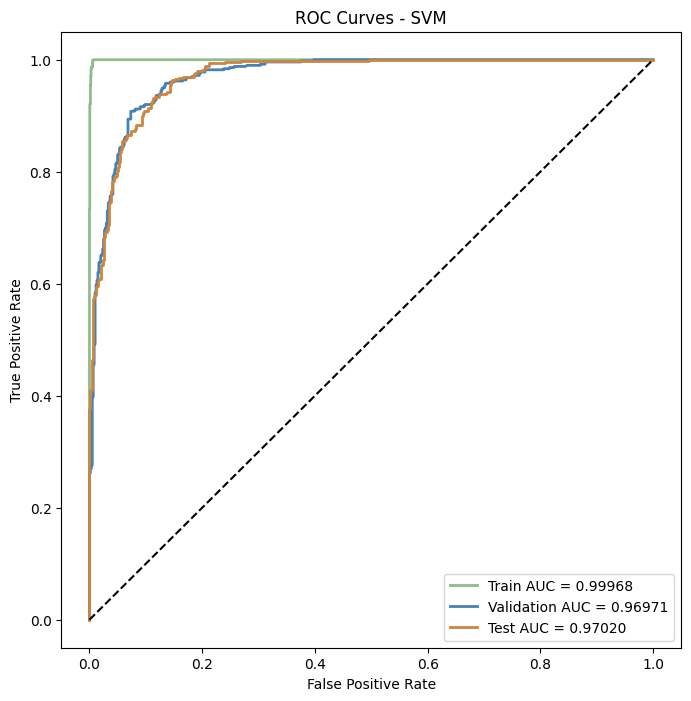

In [16]:
# Predict decision values for each class
y_train_score = best_model.predict_proba(train_difference_array)[:, 1]
y_test_score = best_model.predict_proba(test_difference_array)[:, 1]
y_val_score = best_model.predict_proba(validation_difference_array)[:, 1]

# Compute ROC curve and AUC for each set
fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, y_train_score, drop_intermediate=False)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, y_test_score, drop_intermediate=False)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_val, tpr_val, thresholds_val = roc_curve(validation_labels, y_val_score, drop_intermediate=False)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot ROC curve
plt.figure(figsize=(8, 8))

plt.plot(fpr_train, tpr_train, color='darkseagreen', lw=2, label=f'Train AUC = {roc_auc_train:.5f}')
plt.plot(fpr_val, tpr_val, color='steelblue', lw=2, label=f'Validation AUC = {roc_auc_val:.5f}')
plt.plot(fpr_test, tpr_test, color='peru', lw=2, label=f'Test AUC = {roc_auc_test:.5f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - SVM')
plt.legend()
plt.show()

In [17]:
def find_tpr_at_fpr(fpr, tpr, target_fpr):
    return np.interp(target_fpr, fpr, tpr)

In [18]:
target_fprs = [0.1, 0.01, 0.001]
tpr_at_target_fpr_train = [find_tpr_at_fpr(fpr_train, tpr_train, fpr) for fpr in target_fprs]
tpr_at_target_fpr_test = [find_tpr_at_fpr(fpr_test, tpr_test, fpr) for fpr in target_fprs]
tpr_at_target_fpr_val = [find_tpr_at_fpr(fpr_val, tpr_val, fpr) for fpr in target_fprs]

In [19]:
print(tpr_test)

[0.    0.002 0.004 0.006 0.008 0.01  0.012 0.014 0.016 0.018 0.02  0.022
 0.024 0.026 0.028 0.03  0.032 0.034 0.036 0.038 0.04  0.042 0.044 0.046
 0.048 0.05  0.052 0.054 0.056 0.058 0.06  0.062 0.064 0.066 0.068 0.07
 0.072 0.074 0.076 0.078 0.082 0.084 0.086 0.088 0.09  0.092 0.094 0.096
 0.098 0.1   0.102 0.104 0.106 0.108 0.11  0.112 0.114 0.116 0.118 0.12
 0.122 0.124 0.128 0.13  0.132 0.134 0.136 0.138 0.14  0.142 0.144 0.146
 0.148 0.15  0.152 0.154 0.156 0.158 0.16  0.162 0.164 0.166 0.168 0.17
 0.172 0.174 0.178 0.18  0.182 0.184 0.186 0.188 0.192 0.196 0.198 0.2
 0.202 0.204 0.206 0.208 0.212 0.214 0.216 0.218 0.22  0.222 0.224 0.226
 0.228 0.23  0.232 0.234 0.236 0.238 0.24  0.242 0.244 0.246 0.248 0.25
 0.252 0.254 0.256 0.258 0.26  0.262 0.264 0.266 0.268 0.27  0.272 0.274
 0.276 0.278 0.28  0.282 0.284 0.286 0.288 0.29  0.292 0.294 0.298 0.3
 0.302 0.304 0.306 0.308 0.31  0.312 0.314 0.316 0.318 0.32  0.322 0.324
 0.326 0.328 0.33  0.332 0.334 0.336 0.338 0.34  0.342 0.34

In [20]:
print(fpr_test)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [21]:
print("Train")
for tpr, fpr in zip(tpr_at_target_fpr_train, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_train}')

print("Validation")
for tpr, fpr in zip(tpr_at_target_fpr_val, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_val}')

print("Test")
for tpr, fpr in zip(tpr_at_target_fpr_test, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_test}')

Train
TPR at FPR 0.100: 1.000
TPR at FPR 0.010: 1.000
TPR at FPR 0.001: 0.920
             AUC: 0.9996817460317461
Validation
TPR at FPR 0.100: 0.920
TPR at FPR 0.010: 0.584
TPR at FPR 0.001: 0.262
             AUC: 0.9697133333333333
Test
TPR at FPR 0.100: 0.908
TPR at FPR 0.010: 0.580
TPR at FPR 0.001: 0.376
             AUC: 0.9702033333333334
